# Single Photon Counting with FastCCD and CSXTOOLS

## First some imports, using csxtools

In [1]:
import numpy as np
import tifffile

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('sbwnotebook')

from csxtools.fastccd import phocount
from csxtools import make_panel_plot
import timeit

## Function definitions

In [2]:
def get_photons(data):
    results = []
    histograms = []

    for n in range(1, 9):
        c = phocount.photon_count(data, (75,125), n, True)
        h = np.histogram(c[0], bins=100, range=(50, 350))
        results.append(c[0].ravel())
        histograms.append(h[0]) 
    
    hist_x = h[1][:-1]
    results = np.array(results)
    histograms = np.array(histograms)
    
    return (results, hist_x, histograms)


def plot_results(results, hist_x, histograms):
    color=iter(plt.cm.rainbow(np.linspace(0,1,9)))

    plt.subplot(121)
    for x,h in enumerate(histograms):
        plt.plot(hist_x, h, 'o-', c=next(color), label='{}'.format(x+1))
    plt.legend()

    m = np.nanmean(results, axis=1)
    s = np.nanstd(results, axis=1)
    
    ax1 = plt.subplot(122)
    ax1.plot(np.arange(1, 9), m,'bo')
    ax1.set_xlabel('ESUM Value')
    ax1.set_ylabel('Mean Integrated ADU')

    ax2 = ax1.twinx()
    ax2.plot(np.arange(1, 9), s,'rs')
    ax2.set_ylabel('Standard Deviation')

## Load test data
Using test data from:
``/GPFS/xf23id/xf23id1/LBNL_Test_Data/20140410/Fe55-Exp100us-HC5837/bnl2_20140410_normalizedTiffs``

In [3]:
data = []
for x in range(1,661):
    tf = tifffile.TiffFile('/GPFS/xf23id/xf23id1/LBNL_Test_Data/20140410/Fe55-Exp100us-HC5837/bnl2_20140410_normalizedTiffs50count/image{}.tiff'.format(x))
    data.append(tf.pages[0].asarray())
data = np.array(data)
# Only take half the CCD
data = data[:,240:,:]
data[:,:,9::10] = np.nan
print(data.shape)

(660, 238, 960)


## Check the data

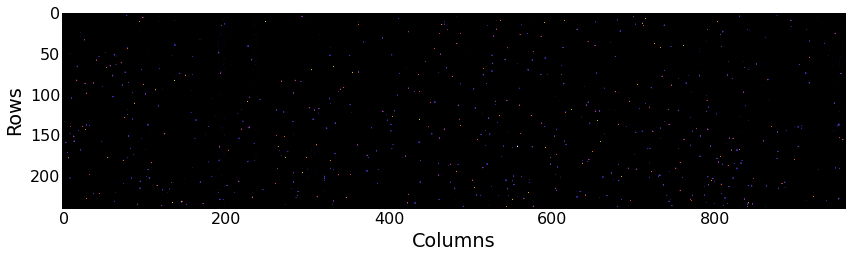

In [4]:
plt.figure()
plt.imshow(data[2], vmin=10, vmax=300, interpolation='none')
plt.xlabel('Columns')
plt.ylabel('Rows')

In [5]:
t = timeit.timeit('phocount.photon_count(data, (150,250), 3)', globals=globals(), number=10)
print("Photon counting array of {} takes {} seconds".format(data.shape, t / 10))

Photon counting array of (660, 238, 960) takes 0.3954857678618282 seconds


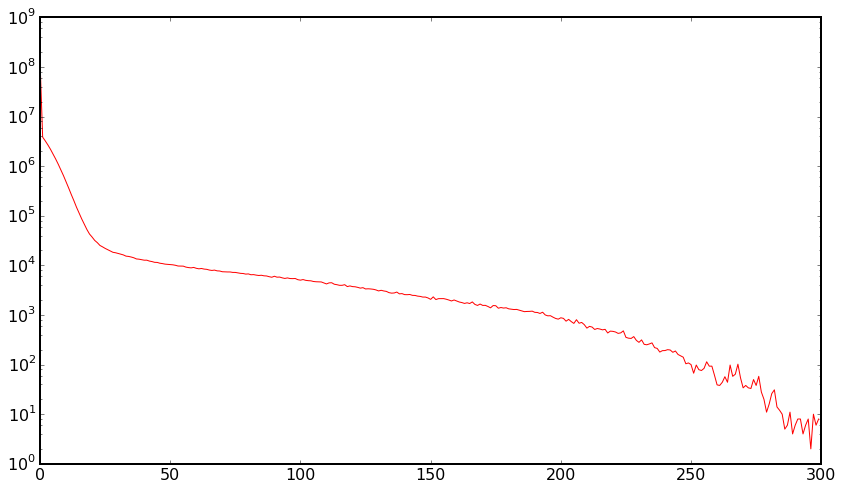

In [6]:
h = np.histogram(data.ravel(), bins=300, range=(0, 300))
fig, ax = plt.subplots()
ax.semilogy(h[1][:-1], h[0], 'r-')

## Run a loop to generate data for diferent ESUM

In [7]:
results, hist_x, histograms = get_photons(data)

## Plot a histogram of integrated ADUs 

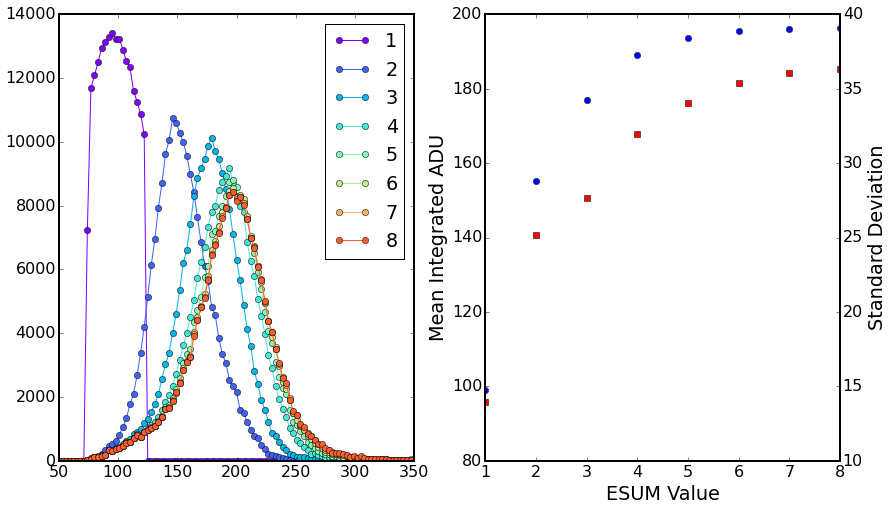

In [8]:
plot_results(results, hist_x, histograms)

## Flatfield Correction

Now generate a flatfield correction based on the mean per column. 

In [10]:
c = phocount.photon_count(data.astype(np.float32), (150,250), 3, True)
inti = c[0]
#inti[:,:,0::10] = np.nan
#inti[:,:,9::10] = np.nan
ff = np.nanmean(inti, axis=(0,1))
ffstd = np.nanstd(inti, axis=(0,1))
ffn = np.nansum(inti, axis=(0,1))

/GPFS/xf23id/users/swilkins/miniconda3/envs/analysis/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:598: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/GPFS/xf23id/users/swilkins/miniconda3/envs/analysis/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1057: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)


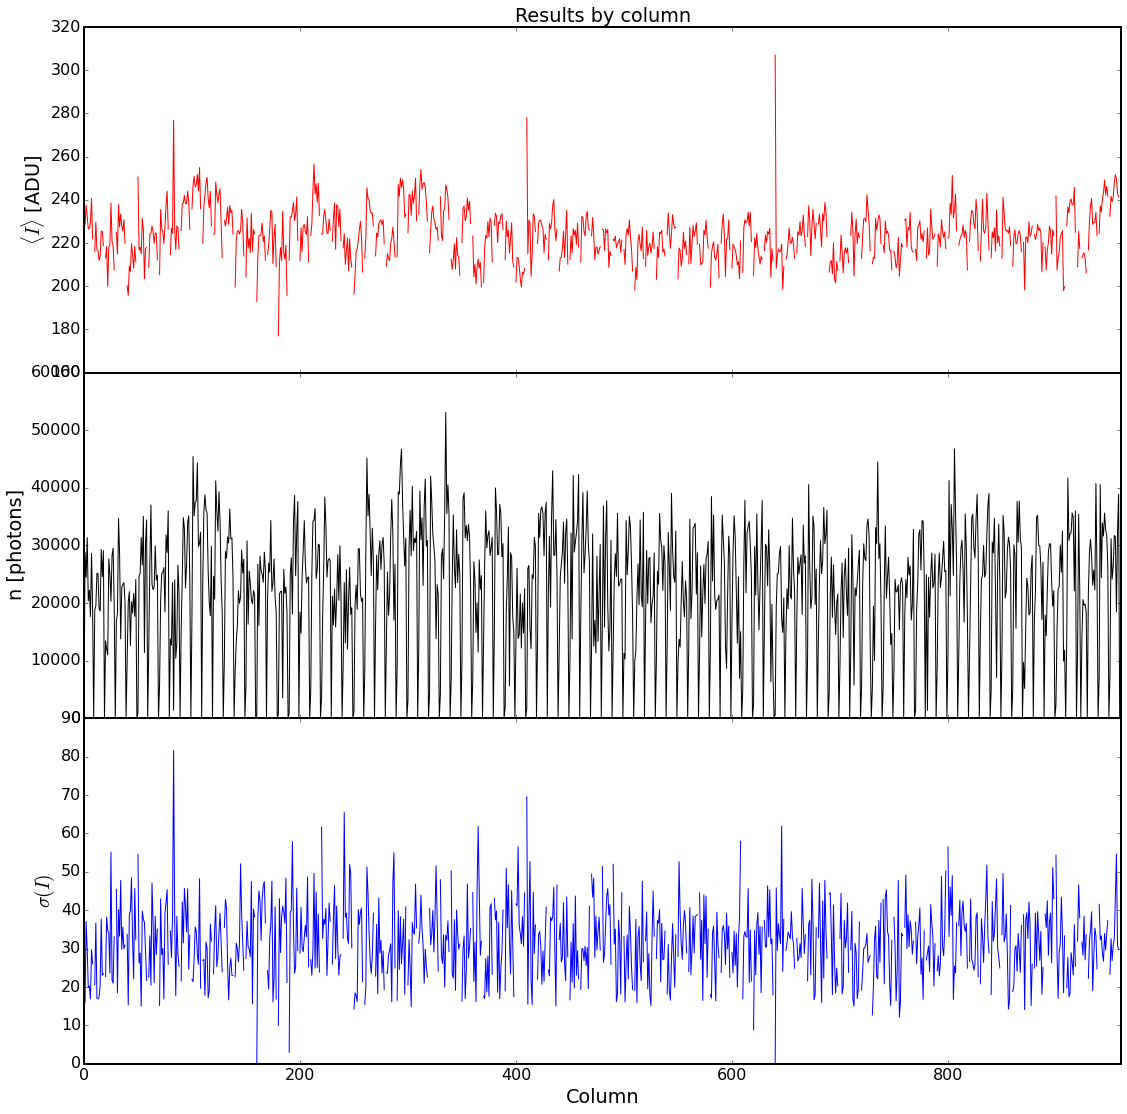

In [11]:
fig = plt.figure(figsize=(18,18))
ax = make_panel_plot(n=3, fig=fig)

ax[2].plot(ff, 'r-')
ax[1].plot(ffn, 'k-')
ax[0].plot(ffstd, 'b-')

ax[2].set_ylabel(r'$\leftangle I \rightangle$ [ADU]')
ax[2].set_title('Results by column ')
ax[1].set_ylabel('n [photons]')
ax[0].set_ylabel('$\sigma (I)$')
ax[0].set_xlabel('Column')

for a in ax:
    a.set_xlim((0,960))